# Dataset import and preprocessing for model estimation

We import the libraries necessary for the analysis and the Stata Python Magic [*IPyStata*](https://github.com/TiesdeKok/ipystata), that allows us to use both Python and Stata in a single notebook, thereby taking advantage of Python libraries to do the preprocessing and plot some graphs for the EDA (Exploratory Data Analysis) and of Stata functions to easily estimate and compare the econometric models. The two environments communicate between each other by importing/exporting Pandas `DataFrame` objects.

In [1]:
import ipystata
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler

IPyStata is loaded in batch mode.


In [2]:
from ipystata.config import config_stata

In [3]:
config_stata('/Applications/Stata/StataSE.app/Contents/MacOS/stataSE')

In [4]:
%%stata 

display "Hello, I am printed in Stata." 


Hello, I am printed in Stata.


In [5]:
path = os.getcwd()

In [6]:
retail_df = pd.read_stata(path + "/Data_sector_2.dta")

In [7]:
retail_df.columns

Index(['index', 'id', 'year', 'assets', 'debt', 'profit', 'profit_cash',
       'sales', 'ad', 'rd', 'firmrisk', 'fv', 'mkt', 'nfirm', 'numfirm',
       'tsales', 'tprofit', 'market_share', 'hhi', 'firmsize', 'mkgrowth',
       's_emphasis', 'ad_intensity', 'mkt_intensity', 'rd_intensity',
       'leverage', 'firm_growth_sales', 'lag_mkt_1', 'lag_mkt_2', 'lag_mkt_3',
       'mkt_growth'],
      dtype='object')

In [8]:
r_1 = retail_df.drop(columns=['nfirm','numfirm','tsales','mkgrowth','tprofit'])

In [9]:
r_1.columns

Index(['index', 'id', 'year', 'assets', 'debt', 'profit', 'profit_cash',
       'sales', 'ad', 'rd', 'firmrisk', 'fv', 'mkt', 'market_share', 'hhi',
       'firmsize', 's_emphasis', 'ad_intensity', 'mkt_intensity',
       'rd_intensity', 'leverage', 'firm_growth_sales', 'lag_mkt_1',
       'lag_mkt_2', 'lag_mkt_3', 'mkt_growth'],
      dtype='object')

# Dataset winsorization

In [10]:
columns = r_1.columns

r_5 = r_1.copy()

In [11]:
tol = 1.5

q1 = np.array([r_5[col].quantile(0.25) for col in r_5.columns])
q3 = np.array([r_5[col].quantile(0.75) for col in r_5.columns])
iqr = q3-q1
lower_whisker = q1 - iqr*tol
upper_whisker = q3 + iqr*tol

for i in range(len(r_5.columns)):
    col = r_5.columns[i]
    r_5.loc[r_5[col] < lower_whisker[i], col] = lower_whisker[i]
    r_5.loc[r_5[col] > upper_whisker[i], col] = upper_whisker[i]

In [12]:
missing = []
for col in r_5.columns:
    if r_5[col].isnull().sum() > 0:
        missing.append(col)

In [13]:
count = 1
years = [i for i in range(2001,2016)]
means, medians = {}, {}
for col in missing:
    m_1 = []
    m_2 = []
    for i in range(2001,2016):
        m_1.append(r_5[r_5['year']==i][col].mean())
        m_2.append(r_5[r_5['year']==i][col].median())
    means[col], medians[col] = m_1, m_2
    count += 1

/usr/local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [14]:
for col in missing:
    for row in range(len(r_5)):
        year = r_5.loc[row,'year']
        if year != 2000 and np.isnan(r_5.loc[row,col]):
            r_5.loc[row,col] = medians[col][int(year-2001)]

In [15]:
print(f'We have missing values for the following variables: ', end='')
print(*missing, sep = ', ')

We have missing values for the following variables: firm_growth_sales, lag_mkt_1, lag_mkt_2, lag_mkt_3, mkt_growth


In [16]:
r_5.head()

,index,id,year,assets,debt,profit,profit_cash,sales,ad,rd,...,s_emphasis,ad_intensity,mkt_intensity,rd_intensity,leverage,firm_growth_sales,lag_mkt_1,lag_mkt_2,lag_mkt_3,mkt_growth
0,0.0,2.0,2000.0,13.413,0.949,1.104,2.731,25.521,0.439,0.0,...,0.032729,0.017202,0.197014,0.0,0.070752,NaN,NaN,NaN,NaN,NaN
1,1.0,2.0,2001.0,11.400,0.764,0.437,-0.290,21.117,0.588,0.0,...,0.051579,0.027845,0.189279,0.0,0.067018,-0.181937,5.028,NaN,NaN,NaN
2,2.0,2.0,2002.0,10.545,3.067,0.743,0.331,22.020,0.541,0.0,...,0.051304,0.024569,0.186421,0.0,0.290849,0.041873,3.997,5.028,NaN,NaN
3,3.0,2.0,2003.0,11.072,2.720,1.302,0.752,26.209,0.590,0.0,...,0.053288,0.022511,0.149681,0.0,0.245665,0.174152,4.105,3.997,5.028,-0.219769
4,4.0,2.0,2004.0,10.282,2.749,1.200,-0.442,28.642,0.634,0.0,...,0.061661,0.022135,0.141924,0.0,0.267360,0.088771,3.923,4.105,3.997,0.017013


Text(0.5, 1.0, 'After outliers recoding')

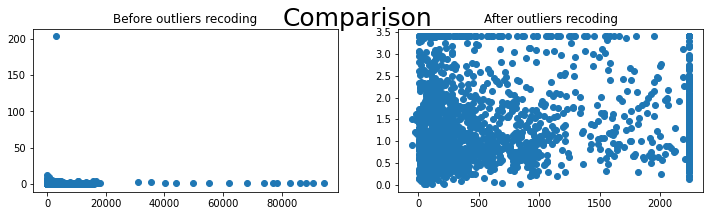

In [17]:
fig = plt.figure(figsize=(12,3))
fig.tight_layout(pad=8)
fig.suptitle('Comparison', size=25)

ax1 = fig.add_subplot(121)
one = ax1.scatter(r_1['mkt'], r_1['fv'])
ax1.set_title('Before outliers recoding')

ax2 = fig.add_subplot(122)
two = ax2.scatter(r_5['mkt'], r_5['fv'])
ax2.set_title('After outliers recoding')

In [18]:
r_5.to_stata('Data_sector_5.dta')

# Correlation matrices

<AxesSubplot:>

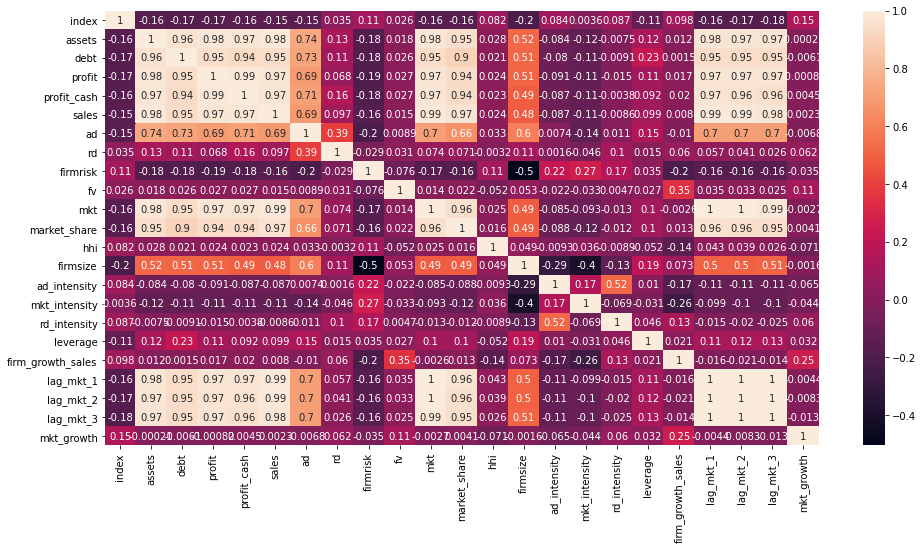

In [19]:
corr_matrix = r_1.drop(columns=['id','year','s_emphasis']).corr()

plt.figure(figsize=(16,8))
sns.heatmap(corr_matrix, annot=True)

Since our focal variable is `mkt` and it is very highly correlated with `assets`, `debt`, `profit`, `profit_cash`, `sales`, `market_share`, `lag_mkt_1`, `lag_mkt_2` and `lag_mkt_3`, we do not include these variables in our models. Moreover, as anticipated before, we use the log-transformation of `sales` as a measure of the firm size and here we can notice that it does not have multicollinearity problems with the focal variable.

<AxesSubplot:>

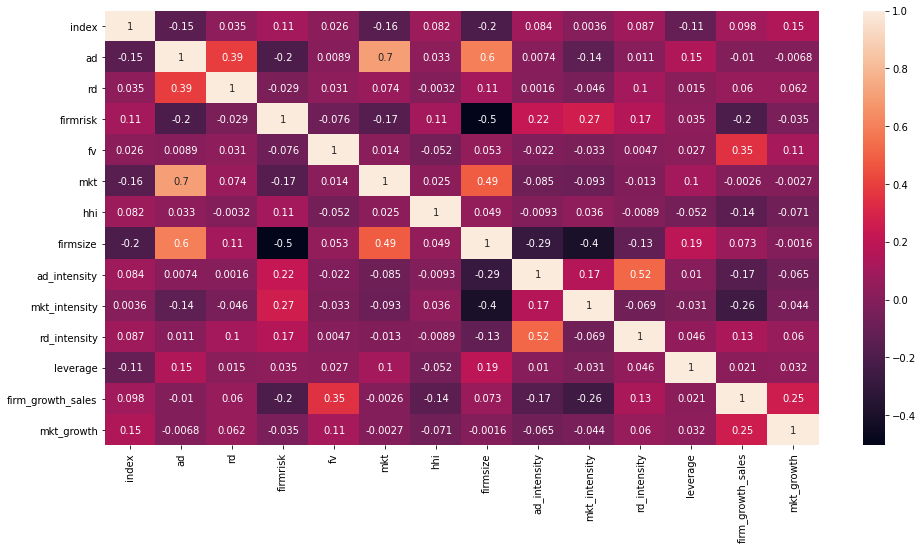

In [20]:
corr_matrix = r_1.drop(columns=['id','year','assets','debt','profit','profit_cash','sales','market_share','lag_mkt_1','lag_mkt_2','lag_mkt_3','s_emphasis']).corr()

plt.figure(figsize=(16,8))
sns.heatmap(corr_matrix, annot=True)

# Model estimation

We now think about which variables to include in our model according to our motivation and the objective of our analysis. \
We already anticipated that `mkt` is our focal variable. Our goal now is to decide which control variables and interaction effects to include in the model, in order to control for the omitted variable bias and eventual non-linearities.

## Hausman test

We carry out the Hausman test to decide whether to use the fixed effect or random effect panel data regression.

In [49]:
%%stata -d r_1

xtset id year

xtreg fv mkt ad rd mkt_intensity ad_intensity rd_intensity firmsize hhi firmrisk leverage firm_growth_sales mkt_growth c.mkt#c.leverage c.mkt#c.firmrisk c.mkt#c.mkt i.year, fe
estimates store fixed

xtreg fv mkt ad rd mkt_intensity ad_intensity rd_intensity firmsize hhi firmrisk leverage firm_growth_sales mkt_growth c.mkt#c.leverage c.mkt#c.firmrisk c.mkt#c.mkt i.year, re
estimates store random

hausman fixed random


       panel variable:  id (unbalanced)
        time variable:  year, 2000 to 2015, but with gaps
                delta:  1 unit
note: 2015.year omitted because of collinearity

Fixed-effects (within) regression               Number of obs     =      1,262
Group variable: id                              Number of groups  =        186

R-sq:                                           Obs per group:
     within  = 0.2491                                         min =          1
     between = 0.0027                                         avg =        6.8
     overall = 0.0532                                         max =         13

                                                F(26,1050)        =      13.40
corr(u_i, Xb)  = -0.3181                        Prob > F          =     0.0000

-----------------------------------------------------------------------------------
               fv |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
------------------+---------------

Since the p-value of the Hausman test is less than any commonly chosen significance level, we use the fixed effect panel data regression and we will stick to this choice for the model comparison.

## Model comparison

Model (1):
$$\text{fv}_{it} = \alpha_i + \beta_1\text{mkt}_{it} + \beta_2\text{ad}_{it} + \beta_3\text{rd}_{it} + \beta_4\text{mkt_intensity}_{it} + \beta_5\text{ad_intensity}_{it} + \beta_6\text{rd_intensity}_{it}$$ 
$$+ \beta_7\text{firmsize}_{it} + \beta_8\text{hhi}_{it} + \beta_9\text{firmrisk}_{it} + \beta_{10}\text{leverage}_{it} + \beta_{11}\text{firm_growth_sales}_{it}$$
$$+ \beta_{12}\text{mkt_growth}_{it} + \beta_{13}\text{mkt}^2_{it} + \beta_{14}\text{mkt}_{it}\cdot\text{firmrisk}_{it} + \beta_{15}\text{mkt}_{it}\cdot \text{leverage}_{it} + \sum_{t \in \text{Years}}\delta_t\text{Year}_{t} +\epsilon_{it}$$

In [48]:
%%stata -d r_1

xtset id year
xtreg fv mkt ad rd mkt_intensity ad_intensity rd_intensity firmsize hhi firmrisk leverage firm_growth_sales mkt_growth c.mkt#c.leverage c.mkt#c.firmrisk c.mkt#c.mkt i.year, fe

vif, uncentered


       panel variable:  id (unbalanced)
        time variable:  year, 2000 to 2015, but with gaps
                delta:  1 unit
note: 2015.year omitted because of collinearity

Fixed-effects (within) regression               Number of obs     =      1,262
Group variable: id                              Number of groups  =        186

R-sq:                                           Obs per group:
     within  = 0.2491                                         min =          1
     between = 0.0027                                         avg =        6.8
     overall = 0.0532                                         max =         13

                                                F(26,1050)        =      13.40
corr(u_i, Xb)  = -0.3181                        Prob > F          =     0.0000

-----------------------------------------------------------------------------------
               fv |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
------------------+---------------

The panel data regression model is jointly statistically significant and at least one firm-specific time-independent fixed effect is significantly different from 0, however some variables have VIFs much higher than 10, thereby indicating the presence of a multicollinearity issue.
Thus, we should eliminate some variables from the model. We try to eliminate `ad`, `rd`, `firmsize` and `hhi`, since their effects are already partially controlled by the previously created variables `ad_intensity` and `rd_intensity`, whereas it is important to keep `firmrisk` and `leverage` because they control for the impact of different forms of risk on market value, which is an input to the `fv` variable. Moreover, we once again underline that many observations have `rd` equal to zero and therefore this variable might not contribute to improve the model.
The interaction terms have very high VIFs, but at the same time we prefer to keep an interaction term involving a variable measuring risk. As a result, we remove the interaction term involving risk measure with higher VIF, i.e. `mkt*leverage`, and the squared term `mkt*mkt`.

Model (2):
$$\text{fv}_{it} = \alpha_i + \beta_1\text{mkt}_{it} + \beta_2\text{mkt_intensity}_{it} + \beta_3\text{ad_intensity}_{it} + \beta_4\text{rd_intensity}_{it}$$ 
$$+ \beta_5\text{firmrisk}_{it} + \beta_6\text{leverage}_{it} + \beta_7\text{firm_growth_sales}_{it}$$
$$+ \beta_8{\text{mkt_growth}_{it} + \beta_9\text{mkt}_{it}\cdot\text{firmrisk}_{it} + \sum_{t \in \text{Years}}}\delta_t\text{Year}_{t} + \epsilon_{it}$$

In [23]:
%%stata -d r_1

xtset id year
xtreg fv mkt mkt_intensity ad_intensity rd_intensity firmrisk leverage firm_growth_sales mkt_growth c.mkt#c.firmrisk i.year, fe

vif, uncentered


       panel variable:  id (unbalanced)
        time variable:  year, 2000 to 2015, but with gaps
                delta:  1 unit

Fixed-effects (within) regression               Number of obs     =      1,262
Group variable: id                              Number of groups  =        186

R-sq:                                           Obs per group:
     within  = 0.2380                                         min =          1
     between = 0.0092                                         avg =        6.8
     overall = 0.0644                                         max =         13

                                                F(21,1055)        =      15.69
corr(u_i, Xb)  = -0.3182                        Prob > F          =     0.0000

-----------------------------------------------------------------------------------
               fv |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
------------------+---------------------------------------------------------------

The panel data regression model is jointly statistically significant and at least one firm-specific time-independent fixed effect is significantly different from 0 and all VIFs are higher than 10 except one, the one for the interaction term `mkt*firmrisk`, which however is only slightly higher than 10.
Moreover, the focal variable `mkt` is not statistically significant. Now we try to run the model in the winsorized dataset, since we have noticed that there may be a few (very extreme) outliers that might significantly affect the model estimation, where the outliers for each variable are defined as the points farther away at least 1.5 times (chosen critical value) the variable interquartile range from the variable median.
(Source: The Future of Data Analysis, J. W. Tukey, Annals of Mathematical Statistics)

In [47]:
%%stata -d r_5

xtset id year
xtreg fv mkt mkt_intensity ad_intensity rd_intensity firmrisk leverage firm_growth_sales mkt_growth c.mkt#c.firmrisk i.year, fe

vif, uncentered


       panel variable:  id (unbalanced)
        time variable:  year, 2000 to 2015, but with gaps
                delta:  1 unit
note: rd_intensity omitted because of collinearity
note: 2015.year omitted because of collinearity

Fixed-effects (within) regression               Number of obs     =      1,608
Group variable: id                              Number of groups  =        240

R-sq:                                           Obs per group:
     within  = 0.3345                                         min =          1
     between = 0.0596                                         avg =        6.7
     overall = 0.1730                                         max =         13

                                                F(20,1348)        =      33.87
corr(u_i, Xb)  = -0.1311                        Prob > F          =     0.0000

-----------------------------------------------------------------------------------
               fv |      Coef.   Std. Err.      t    P>|t|     [95%

# Marginal effects

Based on the last model, we further investigate the impact of the interaction effect `mkt*firmrisk`, by computing and plotting the marginal effect of `mkt` on `fv` at different levels of `firmrisk`.

In [25]:
firmrisk_min, firmrisk_max = r_5.describe().loc["min", "firmrisk"], r_5.describe().loc["max", "firmrisk"]

In [26]:
firmrisk_min, firmrisk_max

(0.0027305585637170267, 0.06828482245578929)

In [27]:
%%stata -d r_5

xtset id year
xtreg fv mkt mkt_intensity ad_intensity rd_intensity firmrisk leverage firm_growth_sales mkt_growth c.mkt#c.firmrisk i.year, fe

margins, dydx(mkt) at(firmrisk=(0.0027305585637170267(0.01)0.06828482245578929))


       panel variable:  id (unbalanced)
        time variable:  year, 2000 to 2015, but with gaps
                delta:  1 unit
note: rd_intensity omitted because of collinearity

Fixed-effects (within) regression               Number of obs     =      1,608
Group variable: id                              Number of groups  =        240

R-sq:                                           Obs per group:
     within  = 0.3345                                         min =          1
     between = 0.0596                                         avg =        6.7
     overall = 0.1730                                         max =         13

                                                F(20,1348)        =      33.87
corr(u_i, Xb)  = -0.1311                        Prob > F          =     0.0000

-----------------------------------------------------------------------------------
               fv |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
------------------+------------

# Checking for myopic management

To further understand the firms' strategic plans in the retailing sector, we also check for the presence of myopic management behaviors among them in the 2001-2015 period.
We estimated the following fixed-effect autoregressive panel data forecast models, discussed in "The Theory and Practice of Myopic Management", N. Mizik.
$$ \text{roa}_{it} = \alpha_{\text{roa}, i} + \phi_{\text{roa}}\text{roa}_{i,t-1} + \sum_{t=2001}^{2015}\delta_{\text{roa}, t}\text{Year}_t + \epsilon_{\text{roa}, it} $$
$$ \text{mkt}_{it} = \alpha_{\text{mkt}, i} + \phi_{\text{mkt}}\text{mkt}_{i,t-1} + \sum_{t=2001}^{2015}\delta_{\text{mkt}, t}\text{Year}_t + \epsilon_{\text{mkt}, it} $$
$$ \text{rd}_{it} = \alpha_{\text{rd}, i} + \phi_{\text{rd}}\text{rd}_{i,t-1} + \sum_{t=2001}^{2015}\delta_{\text{rd}, t}\text{Year}_t + \epsilon_{\text{rd}, it} $$
Myopic behaviors are identified if the following conditions are satisfied:
* $\text{roa}_{it} - \text{roa_hat}_{it} > 0 $
* $\text{mkt}_{it} - \text{mkt_hat}_{it} < 0 $
* $\text{rd}_{it} - \text{rd_hat}_{it} < 0 $

In [28]:
%%stata -d r_1 -o r_1

gen roa = profit/assets

In [29]:
%%stata -d r_1 -o r_1

xtset id year
gen lag_roa_1 = l.roa
gen lag_rd_1 = l.rd


       panel variable:  id (unbalanced)
        time variable:  year, 2000 to 2015, but with gaps
                delta:  1 unit
(314 missing values generated)
(314 missing values generated)


In [30]:
%%stata -d r_1 -o r_1

xtset id year
xtreg roa lag_roa_1 i.year, fe
predict roa_hat


       panel variable:  id (unbalanced)
        time variable:  year, 2000 to 2015, but with gaps
                delta:  1 unit

Fixed-effects (within) regression               Number of obs     =      1,740
Group variable: id                              Number of groups  =        242

R-sq:                                           Obs per group:
     within  = 0.3836                                         min =          1
     between = 0.5520                                         avg =        7.2
     overall = 0.6520                                         max =         15

                                                F(15,1483)        =      61.53
corr(u_i, Xb)  = 0.5025                         Prob > F          =     0.0000

------------------------------------------------------------------------------
         roa |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
   lag_roa_1 

In [31]:
%%stata -d r_1 -o r_1

xtset id year
xtreg mkt lag_mkt_1 i.year, fe
predict mkt_hat


       panel variable:  id (unbalanced)
        time variable:  year, 2000 to 2015, but with gaps
                delta:  1 unit

Fixed-effects (within) regression               Number of obs     =      1,740
Group variable: id                              Number of groups  =        242

R-sq:                                           Obs per group:
     within  = 0.9791                                         min =          1
     between = 0.9993                                         avg =        7.2
     overall = 0.9973                                         max =         15

                                                F(15,1483)        =    4634.55
corr(u_i, Xb)  = 0.9351                         Prob > F          =     0.0000

------------------------------------------------------------------------------
         mkt |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
   lag_mkt_1 

In [32]:
%%stata -d r_1 -o r_1

xtset id year
xtreg rd lag_rd_1 i.year, fe
predict rd_hat


       panel variable:  id (unbalanced)
        time variable:  year, 2000 to 2015, but with gaps
                delta:  1 unit

Fixed-effects (within) regression               Number of obs     =      1,740
Group variable: id                              Number of groups  =        242

R-sq:                                           Obs per group:
     within  = 0.9960                                         min =          1
     between = 0.9999                                         avg =        7.2
     overall = 0.9975                                         max =         15

                                                F(15,1483)        =   24615.14
corr(u_i, Xb)  = 0.5319                         Prob > F          =     0.0000

------------------------------------------------------------------------------
          rd |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
    lag_rd_1 

In [33]:
roa_forecast_errors = (r_1["roa"] - r_1["roa_hat"]).dropna()

In [34]:
roa_forecast_errors

1      -0.060912
2      -0.019146
3       0.026266
4      -0.006278
5      -0.022223
          ...   
2048    0.046879
2050   -0.302088
2051   -0.291198
2052    0.255216
2053   -0.063695
Length: 1740, dtype: float32

In [35]:
len(roa_forecast_errors)

1740

In [36]:
len(roa_forecast_errors[roa_forecast_errors > 0])/len(roa_forecast_errors)

0.5609195402298851

In [37]:
mkt_forecast_errors = (r_1["mkt"] - r_1["mkt_hat"]).dropna()

In [38]:
mkt_forecast_errors

1      -147.232452
2      -158.315109
3      -134.554398
4      -188.023544
5      -249.395996
           ...    
2048    274.274170
2050   -185.599609
2051   -156.846756
2052   -216.526413
2053   -213.998978
Length: 1740, dtype: float32

In [39]:
len(mkt_forecast_errors)

1740

In [40]:
len(mkt_forecast_errors[mkt_forecast_errors < 0])/len(mkt_forecast_errors)

0.843103448275862

In [41]:
rd_forecast_errors = (r_1["rd"] - r_1["rd_hat"]).dropna()

In [42]:
rd_forecast_errors

1       1.941974
2       1.475038
3       1.442618
4       0.970986
5      -0.196473
          ...   
2048    3.336887
2050   -5.586021
2051   -2.704022
2052   -1.720892
2053    3.336887
Length: 1740, dtype: float32

In [43]:
len(rd_forecast_errors)

1740

In [44]:
len(rd_forecast_errors[rd_forecast_errors < 0])/len(rd_forecast_errors)

0.4614942528735632

In [45]:
count = 0

for i in range(0, len(roa_forecast_errors)):
    if roa_forecast_errors.index.tolist()[i] != mkt_forecast_errors.index.tolist()[i] or roa_forecast_errors.index.tolist()[i] != rd_forecast_errors.index.tolist()[i] or mkt_forecast_errors.index.tolist()[i] != rd_forecast_errors.index.tolist()[i]:
        count += 1
        
count

0

In [46]:
count = 0
l = []

for i in roa_forecast_errors.index.tolist():
    if roa_forecast_errors.loc[i] > 0 and mkt_forecast_errors.loc[i] < 0 and rd_forecast_errors.loc[i] < 0:
        count += 1
        l.append(i)

print(f"A total of {count/len(roa_forecast_errors)} of sample observations are classified as instances in which myopic management potentially takes place")

A total of 0.20689655172413793 of sample observations are classified as instances in which myopic management potentially takes place
